In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from head import opentrons
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pdb
from matplotlib import cm
import matplotlib
from scipy.spatial import distance

INFO: Using numpy backend


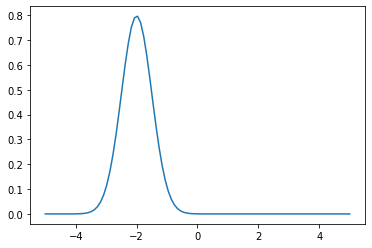

In [3]:
class Simulator:
    def __init__(self):
        self.domain = np.linspace(-5,5,num=100)
        
    def generate(self, mu, sig):
        scale = 1/(np.sqrt(2*np.pi)*sig)
        return scale*np.exp(-np.power(self.domain - mu, 2.) / (2 * np.power(sig, 2.)))
    
    def process_batch(self, Cb, fname):
        out = []
        for c in Cb:
            out.append(self.generate(*c))
        out = np.asarray(out)
        df = pd.DataFrame(out.T, index=self.domain)
        df.to_excel(fname, engine='openpyxl')
        
        return 
    
    def make_target(self, ct):
        return self.domain, self.generate(*ct)
        
sim = Simulator()
target = np.array([-2,0.5])
xt, yt = sim.make_target(target)
fig, ax = plt.subplots()
ax.plot(xt, yt)
plt.show()

In [4]:
# set up your design space using the lower and upper limits
Cmu = [-5,5]
Csig = [0.1,3.5]
bounds = [Cmu, Csig]

In [5]:
optim = opentrons.Optimizer(xt, yt, bounds, 
                            savedir = '../data/opentrons/', batch_size=4)

INFO: Getting suggestions for iteration 0


In [6]:
# random iteration
optim.save()
C0 = np.load('../data/opentrons/0/new_x.npy')
sim.process_batch(C0, '../data/opentrons/0.xlsx')
optim.update('../data/opentrons/0.xlsx')
optim.save()

INFO: Iteriation 0 has an existing directory in ../data/opentrons//0
INFO: Current experiment id : 0
INFO: Iteration : 1
INFO: 0	[2.54576445 0.62671705]	[-3.16885066]
INFO: 1	[1.513381   1.95356851]	[-2.47970605]
INFO: 2	[-3.70705888  0.11765985]	[-5.40922689]
INFO: 3	[4.1697675  2.43781533]	[-2.49703407]
INFO: Iteriation 0 has an existing directory in ../data/opentrons//0


In [7]:
for i in range(1,21):
    # iteration i selection
    optim.suggest_next()
    optim.save()
    # simulate iteration i new_x 
    Ci = np.load('../data/opentrons/%d/new_x.npy'%i)
    sim.process_batch(Ci, '../data/opentrons/%d.xlsx'%i)
    optim.update('../data/opentrons/%d.xlsx'%i)
    optim.save()

INFO: Getting suggestions for iteration 1
INFO: Iteriation 1 has an existing directory in ../data/opentrons//1
INFO: Current experiment id : 4
INFO: Iteration : 2
INFO: 0	[-1.16955758  2.54956724]	[-1.94281125]
INFO: 1	[1.65676882 2.29590519]	[-2.4037776]
INFO: 2	[1.15138141 1.89803897]	[-2.43826914]
INFO: 3	[1.74171509 1.66133073]	[-2.61103749]
INFO: Iteriation 1 has an existing directory in ../data/opentrons//1
INFO: Getting suggestions for iteration 2
INFO: Iteriation 2 has an existing directory in ../data/opentrons//2
INFO: Current experiment id : 8
INFO: Iteration : 3
INFO: 0	[-1.3722021   2.21231345]	[-1.86661434]
INFO: 1	[-0.80436272  2.38349788]	[-1.96844554]
INFO: 2	[-1.50282906  2.77584373]	[-1.94889557]
INFO: 3	[-0.9515815   2.90373691]	[-2.00177932]
INFO: Iteriation 2 has an existing directory in ../data/opentrons//2
INFO: Getting suggestions for iteration 3
INFO: Iteriation 3 has an existing directory in ../data/opentrons//3
INFO: Current experiment id : 12
INFO: Iteration

INFO: Iteration : 21
INFO: 0	[-2.49261263  2.42763454]	[-1.87961853]
INFO: 1	[-4.829397    2.87681899]	[-2.10267067]
INFO: 2	[0.79039703 1.00389332]	[-2.83700013]
INFO: 3	[-5.          2.72373998]	[-2.12664628]
INFO: Iteriation 20 has an existing directory in ../data/opentrons//20


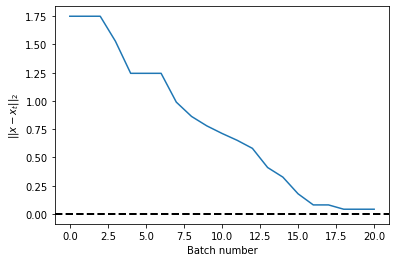

In [8]:
batch_number = np.asarray([v[0]-1 for k,v in optim.expt.items()])

def plot_best_trace(ax, train_x, train_obj, target):
    proximities = distance.cdist(train_x, target.reshape(1,2))
    trace = np.asarray([min(proximities[batch_number<=b]) for b in np.unique(batch_number)])
    return ax.plot(np.unique(batch_number),trace)

fig, ax = plt.subplots()
ax.axhline(0, label='Optimal', ls='--', lw='2.0', c='k')
plot_best_trace(ax, optim.train_x, optim.train_obj, target)
ax.set_xlabel('Batch number')
ax.set_ylabel(r'$||x-x_{t}||_{2}$')
plt.show()

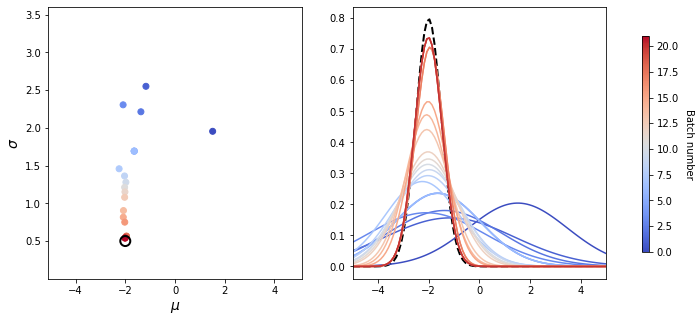

In [9]:
fig, axs = plt.subplots(1,2,figsize=(5*2,5))
batches = np.unique(batch_number)
best_ind = [np.argmax(optim.train_obj.numpy()[batch_number<=b]) for b in batches]
best_loc = optim.train_x.numpy()[best_ind]

ax = axs[0]
ax.scatter(best_loc[:,0], best_loc[:,1], c=batches, cmap='coolwarm')
ax.set_xlim(optim.bounds.numpy()[:,0] + np.asarray([-0.1,0.1]))
ax.set_ylim(optim.bounds.numpy()[:,1] + np.asarray([-0.1,0.1]))
ax.scatter(target[0], target[1], marker='o', 
           s=100, facecolors='none', color='k', lw=2.0)
ax.set_xlabel(r'$\mu$', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)

ax = axs[1]
ax.plot(xt, yt, 'k--', lw=2.0)
cmap = cm.get_cmap('coolwarm')
norm = matplotlib.colors.Normalize(vmin=0, vmax = len(batches))
for i, bind in enumerate(best_ind):
    _, wl, ext, _ = optim.expt[bind]
    ax.plot(wl, ext[0].squeeze(), color=cmap(norm(i)))
ax.set_xlim([-5,5])
cax = plt.axes([0.95, 0.2, 0.01, 0.6])        
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.ax.set_ylabel('Batch number', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
plt.show()